In [10]:
"""Author: Vivian Maria da Silva e Souza 
Instutution: Coppe Del UFRJ"""
from sklearn.naive_bayes import GaussianNB
from sklearn import utils
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import (
    accuracy_score,
    f1_score)
import numpy as np
from itertools import combinations
import os
import configparser
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

configuration_file = 'C:\\Users\\vivia\\.vscode\\cli\\LearnRan\\KFold_v1.ini'
 
if os.path.exists(configuration_file):
    print(f"O arquivo {configuration_file} existe.")
else:
    print(f"O arquivo {configuration_file} não foi encontrado.")

O arquivo C:\Users\vivia\.vscode\cli\LearnRan\KFold_v1.ini existe.


In [11]:
config = configparser.ConfigParser()
config.read(configuration_file)
for section in config.sections():
    print(f"[{section}]")
    for key, value in config.items(section):
        print(f"{key} = {value}")
    print()

rome_slow_close_dir = config['DEFAULT']['rome_slow_close']
rome_static_close_dir = config['DEFAULT']['rome_static_close']
rome_static_far_dir = config['DEFAULT']['rome_static_far']
rome_static_medium_dir = config['DEFAULT']['rome_static_medium']
embb_ues = config['DEFAULT']['default_embb_ues']
mtc_ues = config['DEFAULT']['default_mtc_ues']
urllc_ues = config['DEFAULT']['default_urllc_ues']

possible_cases = [rome_slow_close_dir, rome_static_close_dir, rome_static_far_dir, rome_static_medium_dir]

ues = {}

In [12]:
def calculate_rates_classifier (data_list,n_ue):
    '''dl_mcs, dl_brate, ul_mcs, ul_brate = 0,0,0,0
    last_time = 0'''
    data = []
    for j in range (len(data_list)):
        #time_interval = data_list[j][0] - data_list[j-1][0]
        if np.isinf(data_list[j][1]) or np.isinf(data_list[j][2]): continue 
        data.append(data_list[j][1:])
    '''last_time += time_interval
        dl_mcs += data_list[j-1][1] * time_interval
        dl_brate += data_list[j-1][2] * time_interval
        ul_mcs += data_list[j-1][3] * time_interval
        ul_brate += data_list[j-1][4] * time_interval
    

    dl_mcs = dl_mcs/last_time
    dl_brate = dl_brate/last_time
    ul_mcs = ul_mcs/last_time
    ul_brate = ul_brate/last_time                  
    data = [#dl_mcs, 
        dl_brate, #ul_mcs, 
        ul_brate]'''

    if str(n_ue) in embb_ues: 
        class_ue = 'embb'
    elif str(n_ue) in mtc_ues:
        class_ue = 'mtc'
    else: 
        class_ue = 'urllc'

    return data,class_ue

In [13]:
wished_cols = [0,10,15]
for n_tr in range (18):
    tr = 'tr' + str(n_tr) + '\\'
    for n_exp in range (1,7): 
        exp = 'exp' + str (n_exp) + '\\'
        for n_ue in range (1,41):
            if n_ue%10 != 0: 
                n_bs = n_ue//10 + 1
            else: 
                n_bs = n_ue//10 
            bs = 'bs' + str (n_bs) + '\\'
            a = 'ue'+str(n_ue)+'.csv'
            for traffic_case in possible_cases:
                try:
                    inf_ue = pd.read_csv(traffic_case+tr+exp+bs+a, skiprows=1, usecols = wished_cols,dtype=np.float64)
                    inf_ue = np.array(inf_ue)
                    data = calculate_rates_classifier (inf_ue,n_ue)
                    ues[traffic_case+tr+exp+bs+a] = data
                except FileNotFoundError: pass


In [14]:
def same_len (dic):
    len_max = 0
    for i in dic: 
        if len(dic[i]) > len_max: len_max = len(dic[i])
    for n in dic:
        while len(dic[n]) < len_max:
            n = np.append(dic[n], [0,0])
    return dic

In [19]:

def data_used (b):
    ue_data, ue_classes = [],[]
    len = []
    ues_sl = same_len(ues)
    all_samples = list(ues_sl.keys())
    all_labels = [value[1] for value in ues_sl.values()]  

    used_samples, notused_samples, used_labels, notused_labels = train_test_split(
    all_samples, all_labels, test_size=1/3, stratify=all_labels, random_state=b)

    ues_used = {sample: ues_sl[sample] for sample in used_samples}
    print(len(ues_used))
    ues_notused = {sample: ues_sl[sample] for sample in notused_samples}

    for n in ues_used:
        ue_data.append(ues_used[n][0])
        ue_classes.append(ues_used[n][1])
    for i in ue_data: 
        len.append(len(i))

    return ue_data,ue_classes

In [1]:
data_used(ues)

NameError: name 'data_used' is not defined

In [16]:
from sklearn.neighbors import NearestCentroid
def clusters_classifier (a,k_fold,b):
    n = data_used (b)
    ue_data_classifier = n[0]
    ue_classes_classifier = n[1]
    ue_data_classifier = np.array(ue_data_classifier)
    ue_classes_classifier = np.array(ue_classes_classifier)
    kf = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=a)
    centroid_classifier = NearestCentroid()
    accuracy_scores = []
    for train_index, test_index in kf.split(ue_data_classifier,ue_classes_classifier):
        data_train, data_test = ue_data_classifier[train_index], ue_data_classifier[test_index]
        class_train, class_test = ue_classes_classifier[train_index], ue_classes_classifier[test_index]
        centroid_classifier.fit(data_train, class_train)
        #centros_clusters = centroid_classifier.centroids_
        predictions = centroid_classifier.predict(data_test)
        accuracy = accuracy_score(predictions,class_test)
        accuracy_scores.append(accuracy)
        confusion_matrixes = confusion_matrix(class_test, predictions, labels=["embb", "mtc", "urllc"])
        print (confusion_matrixes)

    mean_accuracy = np.mean(accuracy_scores)
    std_accuracy = np.std(accuracy_scores)
    print (accuracy_scores)
    result = str(mean_accuracy) + ' ; ' + str(std_accuracy)
    return result

In [17]:
print (clusters_classifier(10,3,5))

10024


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (10024,) + inhomogeneous part.

In [3]:
dl_mcs_embb, dl_mcs_mtc, dl_mcs_urllc = [],[],[]
dl_brate_embb, dl_brate_mtc, dl_brate_urllc = [],[],[]  
ul_mcs_embb, ul_mcs_mtc, ul_mcs_urllc = [],[],[]
ul_brate_embb, ul_brate_mtc, ul_brate_urllc = [],[],[]

for d,n in ues.values():
    if n == 'embb':
        dl_mcs_embb.append(d[0])
        dl_mcs_embb.sort()
        dl_brate_embb.append(d[1])
        dl_brate_embb.sort()
        ul_mcs_embb.append(d[2])
        ul_mcs_embb.sort()
        ul_brate_embb.append(d[3])
        ul_brate_embb.sort()

    elif n == 'mtc':
        dl_mcs_mtc.append(d[0])
        dl_mcs_mtc.sort()
        dl_brate_mtc.append(d[1])
        dl_brate_mtc.sort()
        ul_mcs_mtc.append(d[2])
        ul_mcs_mtc.sort()
        ul_brate_mtc.append(d[3])
        ul_brate_mtc.sort()
    else:
        dl_mcs_urllc.append(d[0])
        dl_mcs_urllc.sort()
        dl_brate_urllc.append(d[1])
        dl_brate_urllc.sort()
        ul_mcs_urllc.append(d[2])
        ul_mcs_urllc.sort()
        ul_brate_urllc.append(d[3])
        ul_brate_urllc.sort()






NameError: name 'ues' is not defined

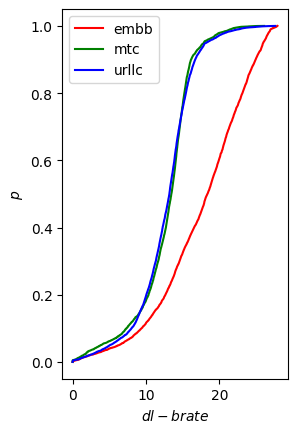

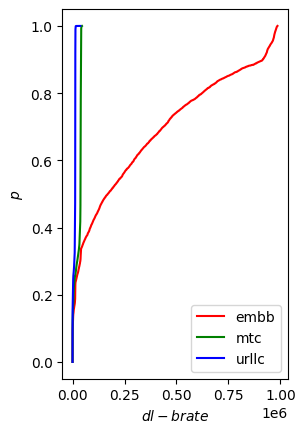

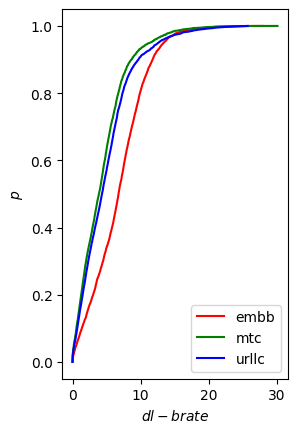

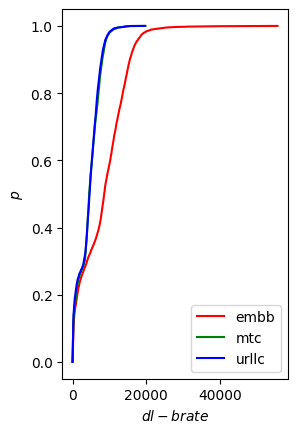

In [ ]:
labels = [[dl_mcs_embb,dl_mcs_mtc,dl_mcs_urllc],[dl_brate_embb,dl_brate_mtc,dl_brate_urllc],
[ul_mcs_embb,ul_mcs_mtc,ul_mcs_urllc],[ul_brate_embb,ul_brate_mtc,ul_brate_urllc]]
classes = ['embb','mtc','urllc']
colors = ['red','green','blue']
ylabel = ['$dl-mcs$', '$dl-brate$', '$ul-mcs$', '$ul-brate$']
for position in range(len(labels)):     
    embb = labels[position][0]
    mtc = labels[position][1]
    urllc = labels[position][2]
    data = [embb,mtc,urllc]
    t = 1. * np.arange(len(labels[position][0])) / (len(labels[position][0]) - 1)
    q = 1. * np.arange(len(labels[position][1])) / (len(labels[position][1]) - 1)
    r = 1. * np.arange(len(labels[position][2])) / (len(labels[position][2]) - 1)
    k = [t,q,r]
    fig = plt.figure()
    # calculate the proportional values of samples
    ax2 = fig.add_subplot(122)
    for i,j in enumerate (colors): 
        p = k[i]
        n = np.array(labels[position][i])
        ax2.plot(n, p, color=j, label=classes[i], alpha=1)

    ax2.set_xlabel(ylabel(position))
    ax2.set_ylabel('$p$')
    ax2.legend()
    plt.show()
    # plot the sorted data:



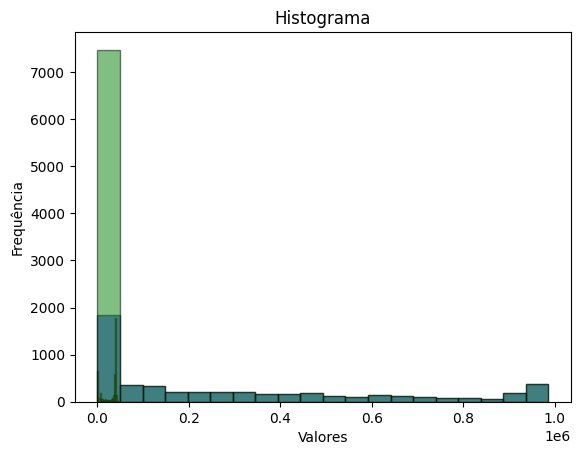

In [82]:

# Criar o histograma
plt.hist(data, bins=20, color='blue', edgecolor='black', alpha=0.5)
plt.hist(data2, bins=20, color='red', edgecolor='black', alpha=0.5)
plt.hist(data3, bins=20, color='green', edgecolor='black', alpha=0.5)

# Adicionar rótulos e título
plt.xlabel('Valores')
plt.ylabel('Frequência')
plt.title('Histograma')

# Mostrar o histograma
plt.show()

10024


KeyboardInterrupt: 